# Retrain Flair NER-Ontonotes-Fast with Human Revised Annotations

There are two main tasks that typically require human interaction with the data in the machine learning process: **data annotation** and **feedback** (see figure below).

Data annotation/ labeling refers to the process of selecting the pieces of information that the AI model must learn to detect and extract. In Konfuzio, an annotation can be defined as the group of characters in a document, its bounding boxes, and the label that has been assign to  (more details in point [4. Labeling](https://konfuzio.com/en/data-extraction-documents-how-to-1/#labelling) of "How to start your project with Konfuzio").

The feedback refers to the process of correcting outputs of an AI model to improve its performance in responding to your aim.

In many cases, you need a **custom model** to solve your problem. This normally requires labeling a dataset based on your purpose and can be a very **time-consuming** process.

What about using an **open-source model** for the labeling? It may not have the **domain knowledge** that you desire but you can bring it in with feedback loops, while you reduce the effort in the labeling process.

Konfuzio allows this interaction.

You can train your Konfuzio model using the Konfuzio Server and provide feedback using its SmartView. However, if you want to use **your own mode**l and/or machine learning pipeline but still benefit from the **Konfuzio functionalities**, such as the dataset hosting and labeling visualization, you can use **Konfuzio SDK** to connect your pipeline to Konfuzio Server in a simple and easy way.

In this tutorial, we will show how you can use the Konfuzio SDK package to include an **easy feedback workflow** in your training pipeline.

We will show how to:

* use the results from an open-source model as annotations in the Konfuzio Server
* provide feedback by simply accept or reject those results
* get back the revised annotations

With these revised annotations you can retrain your model and repeat the loop. By doing this you can **reduce the effort** in the labeling of the data and improve the performance of your model in the domain knowledge that you desire.





 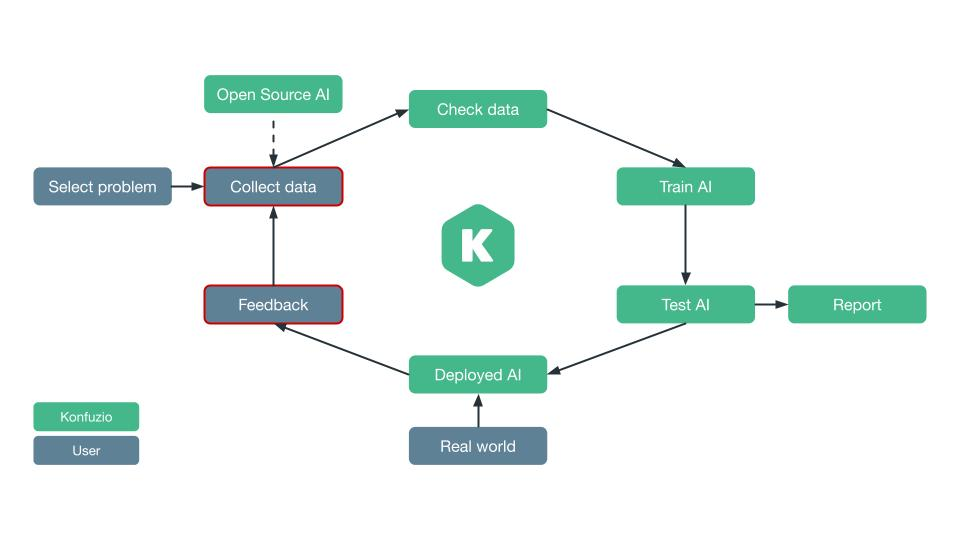

Let's start...

First, be sure you have **installed** and **initialized** the konfuzio_sdk package as shown in the readme of the [repository](https://github.com/konfuzio-ai/Python-SDK).

In [ ]:
!pip install konfuzio-sdk

In [ ]:
!konfuzio_sdk init

Note:  
If you want to switch to a different project, you have to restart the variables in colab (run cell bellow).


In [ ]:
!kill -9 -1

Import the necessary functions from the Konfuzio SDK and other python libraries.

In [ ]:
import os
import glob
import nltk
from konfuzio_sdk.data import Project, Annotation, Document, Label
from konfuzio_sdk.api import upload_file_konfuzio_api
from konfuzio_sdk.utils import get_file_type
from konfuzio_sdk import SUPPORTED_FILE_TYPES

nltk.download('punkt')

Here we will use a model from the library Flair as an example.

Flair is a framework for NLP that allows to use state-of-art models for different tasks, including Named Entity Recognition. It also allows to train your own model to predict custom entities from the text. 

**Named Entity Recognition** is a subtask of information extraction that aims to locate entities in unstructured text such as persons names, organizations, dates, locations, etc.

In the next cells we are installing it and importing the necessary functions. You can skip this if you are using other model.

In [ ]:
!pip install flair

In [5]:
from flair.models import SequenceTagger
from flair.data import Sentence
from flair.trainers import ModelTrainer
from flair.datasets import ColumnCorpus

Load your project.

In [6]:
my_project = Project(id_=YOUR_PROJECT_ID)

In [ ]:
# If in the meantime there was changes in the project in the Konfuzio App, be sure you local project is updated.
# Everytime that there are changes in the Konfuzio App, the local project must be updated to have those changes.
my_project.update()

Upload your documents using the following code.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [8]:
# filter the documents by the supported file types
files_to_check = [f for f in glob.glob('*') if os.path.isfile(f) and not f.endswith('.py')]
files_in_dir = []

for file_path in files_to_check:
  try:
    file_type = get_file_type(file_path)
    if file_type in SUPPORTED_FILE_TYPES:
        files_in_dir.append(file_path)
  except NotImplemented:
    continue

In [9]:
# add the documents to the project

for doc_file in files_in_dir:
  Document(file_path=doc_file, project=my_project).save()

Note:  
If you prefer, use the example documents in the [example folder](https://drive.google.com/drive/folders/1pjJkfIDh07bvbOp4-YOM32aOC4iGUjwW?usp=sharing).

The documents are part of the public dataset [rvl-cdip](https://www.cs.cmu.edu/~aharley/rvl-cdip/).

Alternatively, you can do this step directly on the app by uploading the documents there.  
Follow the instructions in the readme of the [repository](https://github.com/konfuzio-ai/Python-SDK).

Take a look into the text of a document to check its quality.

In [ ]:
# get the documents from the project
my_project.update()
documents = my_project.get_documents_by_status()

doc = documents[0]
print(doc.text)

Use a model to create some first annotations.

Here we will use a pre trained model for Named Entity Recognition (NER) from the flair library. You can use your **own model**.

The model used is the "ner-ontonotes-fast" which is the fast version of the 18-class NER model for English from Flair.

In [ ]:
model = SequenceTagger.load('ner-ontonotes-fast')

Check which labels are in the flair model and chose some.

In [ ]:
labels_available = list(set([tag.split('-')[1] for tag in model.tag_dictionary.get_items() if '-' in tag]))
print(labels_available)

Our example documents are invoices.

We will detect the date of the invoice and the organization which is creating it. it could be used, for example, to group the invoices per company and year.

Therefore, we will use the pretrained model to have some first annotations for **dates** and **organizations** in the documents.



In [13]:
# labels for which we want to create annotations
labels_names = ['DATE', 'ORG']

We need to create the labels in the project accordingly with the labels_names defined above.

In [14]:
for label in labels_names:
    Label(project=my_project, has_multiple_top_candidates=True, text=label).save()

Collect the defined labels and the correspondent label set.

In [15]:
# labels defined in the Konfuzio project that match the ones we want
my_labels = [label for label in my_project.labels if label.name in labels_names]

# correspondent label set id
my_label_sets_ids = [my_label.label_sets[0].id for my_label in my_labels]

Post the results from the pretrained model as annotations in the Konfuzio app.

In [16]:
def annotate_document(document, annotations, labels, label_sets_ids):
    """
    Create annotations in a document.

    Based on a list of possible annotations, filter the ones that match with the
    labels in the project.

    :param document: document object
    :param annotations: list of possible annotations
    :param labels: labels for which the annotations can be created
    :param label_sets_ids: label sets ids that correspondent to the labels
    """
    labels_names = [label.name for label in labels]

    for entity in annotations:
        if entity.tag in labels_names:
            for label, label_set_id in zip(labels, label_sets_ids):
                if label.name == entity.tag:
                    break
            annotation_obj = Annotation(
                document=document,
                document_id=document.id,
                start_offset=entity.start_pos,
                end_offset=entity.end_pos,
                label=label.id,
                label_set_id=label_set_id,
                accuracy=None
            )
            _ = annotation_obj.save()

In [17]:
for doc in documents:
    s = Sentence(doc.text)
    model.predict(s)
    first_results = s.get_spans('ner')
    annotate_document(doc, first_results, my_labels, my_label_sets_ids)

You can view the results directly in the document using the SmartView and **revise** them by accepting or rejecting as described in the point  [7. Give feedback](https://konfuzio.com/en/data-extraction-documents-how-to-1/#how-to-step-1611219481233) of "How to start your project with Konfuzio".

Now you can use the revised annotations to **train a model in the app** or **retrain your local model**.

If you want to train a model in the app, you have first to specify which documents should be used for training.
You can do that in the app by selecting "Add to training data set" as described in the point  [5. Division into training and test data](https://konfuzio.com/en/data-extraction-documents-how-to-1/#how-to-step-1611219345671).

Then, you just have to set the retraining of the project by ticking the box and select the respective execution in the action field [here](https://app.konfuzio.com/admin/server/project/). More detailed instructions in the point [6.Start retraining and evaluate results](https://konfuzio.com/en/data-extraction-documents-how-to-1/#how-to-step-1611219370716).

If you want to retrain your local model, you have to update your local project first so that you get the information of the revised annotations.

In [ ]:
for doc in documents:
  doc.update()

The next step is to define which documents should be used for training.

In [ ]:
# define all uploaded documents as training dataset
for doc in documents:
    doc.dataset_status = 2
    doc.save()

The training documents can now be accessed by the attribute **documents** of the project.

In [ ]:
print(len(my_project.documents))

Then, use the reviewed annotations to retrain your model.

To get the annotations in a document, you just have to use the method **annotations()**.

The cell bellow shows how many annotations are in the first document in the training set.

In [ ]:
print(len(my_project.documents[0].annotations()))

An example of how to get the data in the format necessary to retrain the flair model is shown bellow.

This example is merely demonstrative. You might want to adapt the data structure and training parameters to your case and/or model.

The flair model requires the data structure to be in the BIO scheme and to be saved in a text file.
In this case, to convert the annotations to the BIO scheme, we only need to get the **start** and **end offsets** of
each annotation and its **label**.
This conversion can be done using the method **get_text_in_bio_scheme()** of the Document class.


In [ ]:
def create_data(file_name, documents):
    """
    Create data structure in the format expected by flair and saves it in a txt file.

    Each word is put on a separate line and there is an empty line after each document. 

    :param file_name: name of the file where to save the data
    :param documents: dataset documents
    """
    with open(file_name, 'w') as f:
        for doc in documents:
            doc.get_text_in_bio_scheme()
            with open(doc.bio_scheme_file_path) as doc_file:
                for line in doc_file:
                    f.write(line)


In [ ]:
n_val = max(round(len(my_project.documents) * 0.3), 1)

create_data('train.txt', my_project.documents[:-n_val])
create_data('dev.txt', my_project.documents[-n_val:])
create_data('test.txt', my_project.test_documents)

After having the data in the expected structure, we can retrain the tagger model loaded in the begining.

In [ ]:
def retrain(model, data_folder='./'):
    """
    Train the existing model for a few more epochs.

    :param tagger: pre trained model
    :param data_folder: folder with the dataset files.
    """
    # define columns
    columns = {0: 'text', 1: 'ner'}

    # initializing the corpus
    with open('train.txt') as train_file:
      train_file.seek(0)
      if not train_file.read(1):
        return "There is no training data. Please assign a training data."
  
    corpus = ColumnCorpus(data_folder, columns, train_file='train.txt', test_file='test.txt', dev_file='dev.txt')

    model = ModelTrainer(model, corpus)
    model.train('resources/taggers/continued_model',
                learning_rate=0.01,
                mini_batch_size=32,
                max_epochs=10)

In [ ]:
# retrain the model
retrain(model)

Repeat the process if you would like.

Thank you!
